In [70]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)

%matplotlib inline

In [48]:
# Data reading

data = pd.read_csv('dataset_31_credit-g.csv')

data.sample(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
282,'>=200',18,'all paid',radio/tv,1445,'no known savings','4<=X<7',4,'male single',none,4,car,49,bank,own,1,'unskilled resident',1,none,yes,good
622,'no checking',48,'existing paid',business,3914,'no known savings','1<=X<4',4,'male div/sep',none,2,'real estate',38,bank,own,1,skilled,1,none,yes,bad
248,'>=200',24,'existing paid',furniture/equipment,1925,'<100','1<=X<4',2,'male single',none,2,'real estate',26,none,own,1,skilled,1,none,yes,good
94,'0<=X<200',12,'existing paid','new car',1318,'>=1000','>=7',4,'male single',none,4,'real estate',54,none,own,1,skilled,1,yes,yes,good
796,'<0',18,'existing paid','used car',7511,'no known savings','>=7',1,'male single',none,4,'life insurance',51,none,'for free',1,skilled,2,yes,yes,bad
317,'0<=X<200',24,'existing paid',furniture/equipment,4351,'no known savings','1<=X<4',1,'female div/dep/mar',none,4,'life insurance',48,none,own,1,'unskilled resident',1,yes,yes,good
903,'no checking',15,'existing paid',radio/tv,1386,'no known savings','1<=X<4',4,'male mar/wid',none,2,'real estate',40,none,rent,1,skilled,1,yes,yes,good
919,'<0',24,'existing paid',furniture/equipment,3345,'<100','>=7',4,'male single',none,2,'life insurance',39,none,rent,1,'high qualif/self emp/mgmt',1,yes,yes,bad
381,'0<=X<200',18,'existing paid','used car',12976,'<100',unemployed,3,'female div/dep/mar',none,4,'no known property',38,none,'for free',1,'high qualif/self emp/mgmt',1,yes,yes,bad
892,'<0',12,'critical/other existing credit','new car',2171,'<100','1<=X<4',4,'male single',none,4,'life insurance',38,bank,own,2,'unskilled resident',1,none,no,good


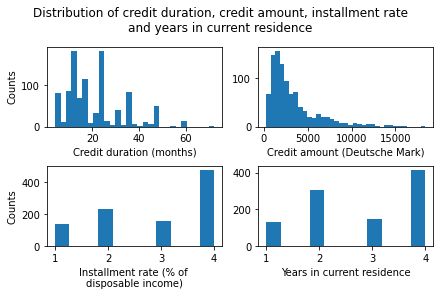

In [49]:
# Distribution of the first four non-categorical features 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of credit duration, credit amount, installment rate\nand years in current residence')

ax[0, 0].hist(data['duration'], bins='auto')
ax[0, 0].set_xlabel('Credit duration (months)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['credit_amount'], bins='auto')
ax[0, 1].set_xlabel('Credit amount (Deutsche Mark)')

ax[1, 0].hist(data['installment_commitment'], bins='auto')
ax[1, 0].set_xlabel('Installment rate (% of \ndisposable income)')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['residence_since'], bins='auto')
ax[1, 1].set_xlabel('Years in current residence')

non_cat_cols = ['duration', 'credit_amount', 'installment_commitment', 'residence_since']

plt.show()

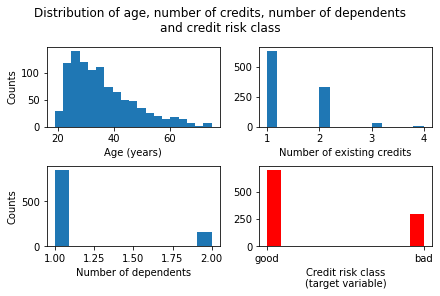

In [50]:
# Distribution of the remaining non-categorical features as well as the target 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of age, number of credits, number of dependents\nand credit risk class')

ax[0, 0].hist(data['age'], bins='auto')
ax[0, 0].set_xlabel('Age (years)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['existing_credits'], bins='auto')
ax[0, 1].set_xlabel('Number of existing credits')

ax[1, 0].hist(data['num_dependents'], bins='auto')
ax[1, 0].set_xlabel('Number of dependents')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['class'], color='r', bins='auto')
ax[1, 1].set_xlabel('Credit risk class\n(target variable)')

non_cat_cols.extend(['age', 'existing_credits', 'num_dependents'])
cat_cols = [col for col in data.columns if col not in non_cat_cols and col != 'class']

plt.show()

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['duration', 'credit_amount',
                                                   'age']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['installment_commitment',
                                                   'residence_since',
                                                   'existing_credits',
                                                   'num_dependents']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['checking_status',
                                                   'credit_histor

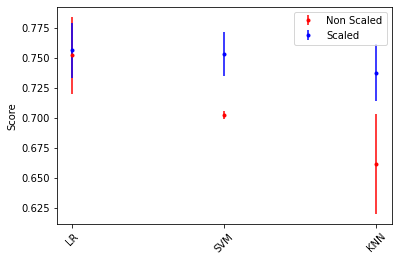

In [73]:
# Train-test-validation split
X = data.loc[:, data.columns != 'class']
y = data['class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0)

# Perform only the required preprocessing of categorical features
X_train_val_trans = pd.get_dummies(X_train_val, columns=cat_cols)

get_score_no_pipe = lambda model: cross_val_score(model, X_train_val_trans, y_train_val)

non_scaled_scores = dict()

non_scaled_scores['LR'] = get_score_no_pipe(LogisticRegression())
non_scaled_scores['SVM'] = get_score_no_pipe(LinearSVC())
non_scaled_scores['KNN'] = get_score_no_pipe(KNeighborsClassifier())

# Creating column transformers and fitting with pipelines
col_transformer = make_column_transformer((RobustScaler(), ['duration', 'credit_amount', 'age']),
                                          (MinMaxScaler(), ['installment_commitment', 'residence_since',
                                                            'existing_credits', 'num_dependents']),
                                          (OneHotEncoder(), cat_cols))

get_score_pipe = lambda model: cross_val_score(make_pipeline(col_transformer, model), X_train_val, y_train_val)

scaled_scores = dict()

scaled_scores['LR'] = get_score_pipe(LogisticRegression())
scaled_scores['SVM'] = get_score_pipe(LinearSVC())
scaled_scores['KNN'] = get_score_pipe(KNeighborsClassifier())

print(make_pipeline(col_transformer, LogisticRegression()))

# Plotting mean and std of the scores (instead of box plot because we only have 5 samples)
ax = plt.subplot()

ax.set_ylabel('Score')

ax.set_xticklabels(non_scaled_scores.keys(), rotation=45)
ax.set_xticks(range(len(non_scaled_scores)))

ax.errorbar(range(len(non_scaled_scores)),
            np.mean(list(non_scaled_scores.values()), axis=1),
            np.std(list(non_scaled_scores.values()), axis=1), 
            linestyle='None', marker='.', color='r', label='Non Scaled')

ax.errorbar(range(len(scaled_scores)),
            np.mean(list(scaled_scores.values()), axis=1),
            np.std(list(scaled_scores.values()), axis=1), 
            linestyle='None', marker='.', color='b', label='Scaled')

ax.legend()

plt.show()